In [1]:
import numpy as np
from tqdm import tqdm
import timeit
from matplotlib import pyplot as plt

import mala

In [16]:
dim = 2
h = 0.1
n = 2000
N_train = 100
N_test = 100

def f(x):
    a = np.ones(dim) / np.sqrt(2*dim)
    return 1/2 * (np.linalg.norm(x-a)**2) - np.log(1 + np.exp(-2 * x.T @ a))

def f_grad(x):
    a = np.ones(dim) / np.sqrt(2*dim)
    return x - a + 2 * a/(1 + np.exp(2* (x.T @ a)))

def pi(x):
    a = np.ones(dim) / np.sqrt(2*dim)
    return 1/(2 * (2 * np.pi)**(dim/2)) * (np.exp(-np.linalg.norm(x-a)**2 /2) + np.exp(-np.linalg.norm(x+a)**2 / 2))


def local_weighted_estimator(X):
    return X.sum(axis=1).mean()

def estimator(XX):
    Pi = np.empty(XX.shape[0])
    for i in tqdm(range(XX.shape[0])):
        Pi[i] = local_weighted_estimator(XX[i])
    return Pi

In [17]:
def ULA_with_burnin(d, step, burn_in, n, f_grad):
    """ MCMC ULA
    Args:
        Md: dimension
        step: stepsize of the algorithm
        burn_in: burn-in period
        n: number of samples after the burn-in
        f_grad: gradient of the potential U
    Returns:
        traj: a numpy array of size (n, d), where the trajectory is stored
        traj_grad: numpy array of size (n, d), where the gradients of the potential U along the trajectory are stored
        traj_noise: numpy array of size (n, d), where the noises along trajectory are stored
    """
    traj = np.zeros((burn_in + n, d))
    traj_grad = np.zeros((burn_in + n, d))
    traj_noise = np.random.randn(burn_in + n, d)
    
    traj[0] = (np.random.normal(0,1,d)).reshape(d)
    traj_grad[0] = f_grad(traj[0])

    for i in range(1,burn_in + n):
        traj[i] = traj[i-1] - step/2*traj_grad[i-1] + np.sqrt(step) * traj_noise[i]
        traj_grad[i] = f_grad(traj[i])
    return traj[burn_in:], traj_grad[burn_in:], traj_noise[burn_in:]

In [18]:
np.random.seed(42)
X_ULA, _, _  = ULA_with_burnin(d=dim, step=h, burn_in=20000, n=100000,f_grad = f_grad)
X, G, Z , U, ac_rate = mala.MALA_with_burnin(d=dim, step=h, burn_in=20000, n=100000,f_grad = f_grad, f = f)

0.99487


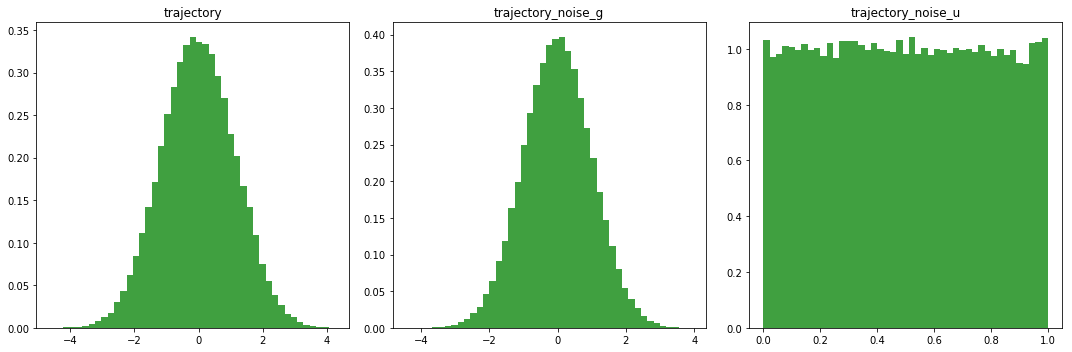

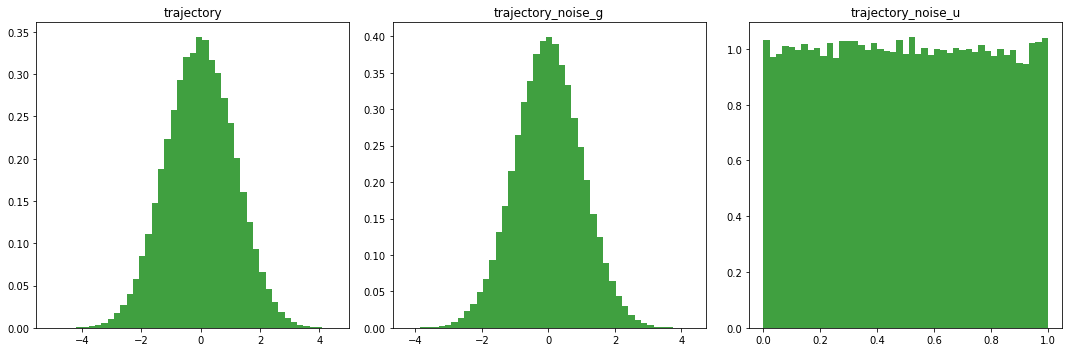

In [19]:
print (ac_rate)
mala.plot_distr(X, Z, U, 0)
mala.plot_distr(X, Z, U, 1)

In [20]:
np.random.seed(123)

XX, GG, ZZ, UU = mala.generate_train_trajectories(X, N_train=N_train,d = dim, step = h, n = n, f_grad=f_grad, f = f)
XX_test, GG_test, ZZ_test, UU_test = mala.generate_test_trajetories(N_test=N_test, d =dim, step=h, 
                                                          burn_in=10000, n = n, f_grad=f_grad, f = f)

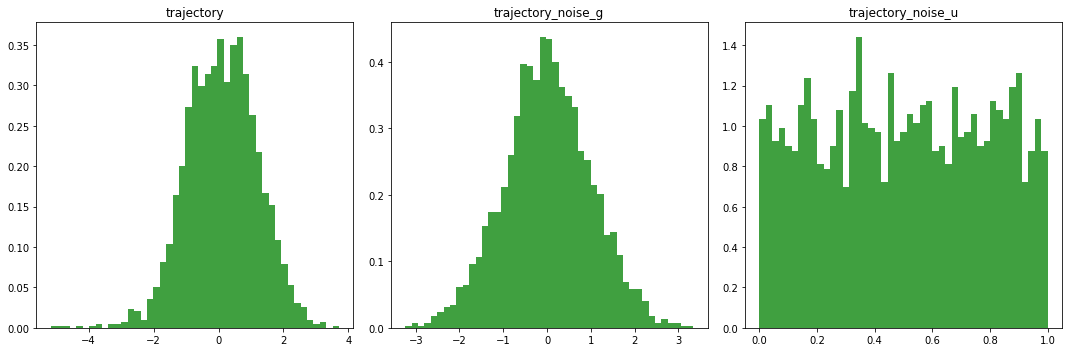

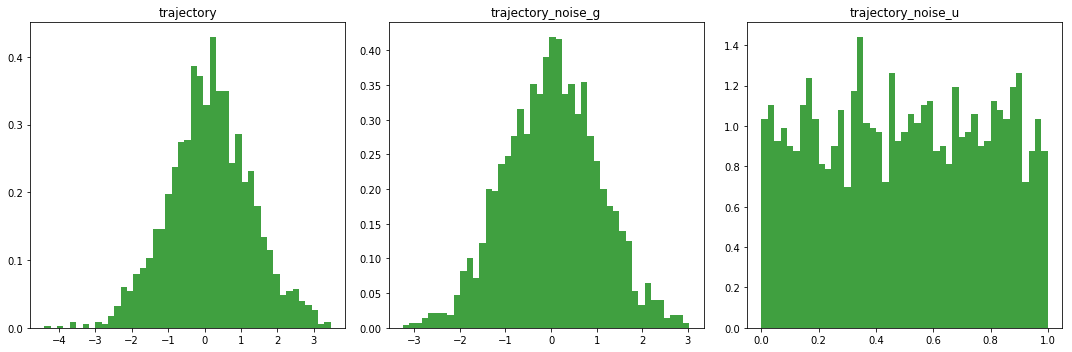

In [8]:
mala.plot_distr(XX[5], ZZ[5], UU[5], 0)
mala.plot_distr(XX[5], ZZ[5], UU[5], 1)

In [30]:
def H(k, x): #Hermite
    if k==0:
        return 1.0
    if k ==1:
        return x
    if k==2:
        return (x**2 - 1)/np.sqrt(2)
    h = hermitenorm(k)(x) /  np.sqrt(math.factorial(k))
    return h

def L(k,x): #Shifted Legandre 
    if k==0:
        return 1.
    elif k==1:
        return np.sqrt(3) * (2*x - 1)
    elif k ==2:
        return np.sqrt(5) * (6*x**2 - 6*x +1)
    else:
        return None
    
def Hermite_val(k_vec,x_vec):
    P = 1.0
    d = x_vec.shape[0]
    for i in range(d):
        P = P * H(k_vec[i],x_vec[i])
    return P

def phi_val(k_vec, x_vec, k, uni):
    return Hermite_val(k_vec, x_vec) * L(k, uni)

In [32]:
def generate_X_poly(train_traj, r, max_deg):
    N_train = train_traj.shape[0]
    N = train_traj.shape[1]
    d = train_traj.shape[2]
    X = np.empty((N_train * (N-r) ,d+1 + int(d*(d+1)/2)))
    all_points = train_traj[:, :N-r].reshape(-1,d)
    poly = PolynomialFeatures(max_deg)
    X = poly.fit_transform(all_points)
    return X, poly.powers_

def generate_y_mean(train_traj, r, f_target = "sum"):
    N_train = train_traj.shape[0]
    N = train_traj.shape[1]
    y = np.zeros(N_train * (N-r))
    if f_target == "sum":
        y = train_traj[:, r:].sum(axis = 2).reshape(-1)
    elif f_target == "sum_squared":
        y = np.square(train_traj[:, r:]).sum(axis = 2).reshape(-1)
    elif f_target == "sum_4th":
        y = (train_traj[:, r:]**4).sum(axis = 2).reshape(-1)
    elif f_target == "exp_sum":
        y = np.exp(train_traj[:, r:].sum(axis =2)).reshape(-1)
    else:
        raise Exception('unrecognized target function')
    return y

In [33]:
def G_pml_fit_mean(train_traj, f_target="sum", max_deg = 1):
    N_train = train_traj.shape[0]
    N = train_traj.shape[1]
    d = train_traj.shape[2]
    Betas = np.zeros((N, d+ 1 + (max_deg-1) * int(d*(d+1)/2)))
    for r in tqdm(range(N)):
        # Linear Regression
        if 0 < max_deg < 3:
            X, degrees = generate_X_poly(train_traj, r, max_deg)
        else:
            raise Exception('max_deg should be 1 or 2')
        y = generate_y_mean(train_traj, r, f_target)

        beta = np.linalg.inv(X.T @ X) @ X.T @ y
        Betas[r] = beta
    return Betas, degrees

In [89]:
def a_plk(traj, traj_grad, p, l, k_vec, step, degrees, Betas):
    dim = traj.shape[1]
    S = 0
    x_hat = traj[l-1] - step*traj_grad[l-1]/2
    Small_s = np.zeros(dim)
    for ind,deg in enumerate(degrees):
        Small_s[:] = 0
        for d, i in enumerate(deg):
            for t in range (i+1):
                for s in range (int(t/2 +1)):
                    if (k_vec[d] == t - 2*s):
                        Small_s[d] = Small_s[d] + comb(N=i, k = t, exact = True) * x_hat[0]**(i-t) * math.factorial(t)*1/math.factorial(s)*1 / np.sqrt(math.factorial(t-2*s)) *np.sqrt(step)**t /2**s
                    else:
                        pass
        S = S + Betas[p-l,ind] * Small_s.prod()
    return S

In [90]:
def M_bias(k_vec,k, traj, traj_grad, traj_noise_g, traj_noise_u, step, degrees, Betas, n_tilde):
    N = traj.shape[0]
    S = 0
    for p in range(N):
        for l in range (p+1):
            if (p-l<n_tilde):   #TRUNCATED
                s = a_plk(traj, traj_grad, p, l, k_vec, step, degrees, Betas)* phi_val(k_vec,traj_noise_g[l],
                                                                                       k, traj_noise_u[l])
                S = S + s
    return S/N

def estimator_bias(k_vec,k, test_traj, test_traj_grad, test_traj_noise_g, test_traj_noise_u, 
                   step, degrees, Betas, n_tilde, n_jobs = -1):
    N_test = test_traj.shape[0]
    M_results = Parallel(n_jobs = n_jobs)(delayed(M_bias)(k_vec,k, test_traj[i], test_traj_grad[i], test_traj_noise_g[i],
                                                          test_traj_noise_u[i], step, degrees, Betas,n_tilde)
                                          for i in range(N_test))
    return np.array(M_results).reshape(-1)

In [91]:
import numpy as np
from scipy.special import comb
from scipy.special import hermitenorm
from tqdm import tqdm
from joblib import Parallel, delayed
from itertools import product
from sklearn.preprocessing import PolynomialFeatures
from matplotlib import pyplot as plt
import math
import ZVnbrosse

In [92]:
f_target = 'sum'
deg = 1
Betas, degrees = G_pml_fit_mean(XX,f_target, max_deg = deg)

100%|██████████| 2000/2000 [00:13<00:00, 153.30it/s]


In [93]:
k_comb = np.zeros((dim,dim), dtype = np.int16)
for i in range(dim):
    k_comb[i,i] = 1

In [94]:
i_test = 0
time_1 = timeit.default_timer()
p = local_weighted_estimator(XX_test[i_test])
print ("mean of target function =", p)
for i in range(len(k_comb)):
    p = p - M_bias(k_comb[i],0, XX_test[i_test],GG_test[i_test], ZZ_test[i_test],UU_test[i_test], h, degrees,Betas,60)
    print ("            (k = {}) = {} [Time:{}]".format(k_comb[i],p,timeit.default_timer()-time_1))

mean of target function = -0.1772333315587197
            (k = [1 0]) = -0.262620644603037 [Time:10.221050333995663]
            (k = [0 1]) = -0.049970585685736535 [Time:20.2825733819991]


In [95]:
P_test = estimator(XX_test)

100%|██████████| 100/100 [00:00<00:00, 11808.95it/s]


In [103]:
M_test = np.empty((len(k_comb),P_test.shape[0]))
for i in range(len(k_comb)):
    M_test[i] = estimator_bias(k_comb[i],0, XX_test, GG_test, ZZ_test,UU_test, h, degrees,Betas,100, n_jobs=3)

In [108]:
res_zv_1 = []
for i in range (XX_test.shape[0]):
    res_zv_1.append(ZVnbrosse.ZVpolyOne(XX_test[i].reshape(-1,dim), GG_test[i].reshape(-1,dim), f_target))
res_zv_1 = np.array(res_zv_1).reshape(-1)

res_zv_2 = []
for i in range (XX_test.shape[0]):
    res_zv_2.append(ZVnbrosse.ZVpolyTwo(XX_test[i].reshape(-1,dim), GG_test[i].reshape(-1,dim), f_target))
res_zv_2 = np.array(res_zv_2).reshape(-1)

res_cv_1 = []
for i in range (XX_test.shape[0]):
    res_cv_1.append(ZVnbrosse.CVpolyOne(XX_test[i].reshape(-1,dim), GG_test[i].reshape(-1,dim), f_target))
res_cv_1 = np.array(res_cv_1).reshape(-1)

res_cv_2 = []
for i in range (XX_test.shape[0]):
    res_cv_2.append(ZVnbrosse.CVpolyTwo(XX_test[i].reshape(-1,dim), GG_test[i].reshape(-1,dim), f_target))
res_cv_2 = np.array(res_cv_2).reshape(-1)

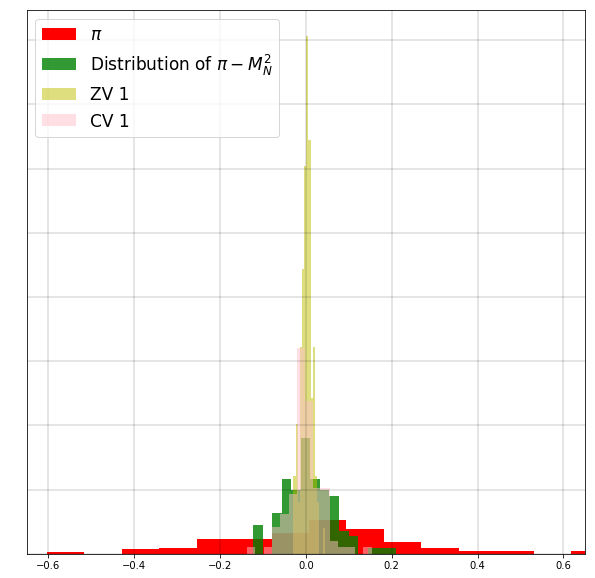

In [109]:
plt.figure(figsize=(10,10))
plt.hist(P_test,15, facecolor='r', density=True, alpha=1, label=r"$\pi$")

plt.hist((P_test-M_test.sum(axis=0)),15, density=True, facecolor='g', alpha=0.8, label="Distribution of $\pi - M^2_N$")

plt.hist(res_zv_1,15, facecolor='y', density=True, alpha=0.5, label="ZV 1")
# plt.hist(res_zv_2,15, facecolor='b', density=True, alpha=0.5, label="ZV 2")
plt.hist(res_cv_1,15, facecolor='pink', density=True, alpha=0.5, label="CV 1")
# plt.hist(res_cv_2,15, facecolor='black', density=True, alpha=0.5, label="CV 2")

plt.legend(loc=2, prop={'size': 17})
plt.grid(linestyle='-', linewidth=0.2, color='black')
plt.tick_params(axis='y',color = 'w', labelcolor = 'w', which='both')
plt.xlim(-0.65, 0.65)
plt.show()

In [110]:
P_test

array([-0.17723333,  0.02411256,  0.0763646 , -0.38199927,  0.33159893,
        0.02802647, -0.28826838, -0.28779397,  0.24116634, -0.18453533,
        0.38114019,  0.12121619,  0.48279688, -0.21857854, -0.21639353,
        0.07730956, -0.03916447,  0.27977645, -0.03492337,  0.20528234,
        0.05919512, -0.38433996, -0.11132403, -0.23558092, -0.08818862,
       -0.06841765,  0.03210873, -0.0383861 ,  0.03990684,  0.04946573,
        0.00426661, -0.19789229,  0.05024916,  0.06202587,  0.04934752,
        0.10215967,  0.01754149,  0.16850218,  0.40498138,  0.17630354,
       -0.27778638, -0.01397538, -0.00822795, -0.40125453, -0.15403072,
        0.11860984, -0.23877029,  0.17882198,  0.24903016, -0.17579627,
        0.21544952, -0.00506822,  0.16033883,  0.15356112, -0.14085172,
       -0.01797781,  0.06874905,  0.23908592,  0.28912747,  0.70480728,
        0.03147592,  0.06037979, -0.13288024,  0.70104085, -0.1019983 ,
        0.06453516,  0.10190705,  0.16746633,  0.01233931,  0.19

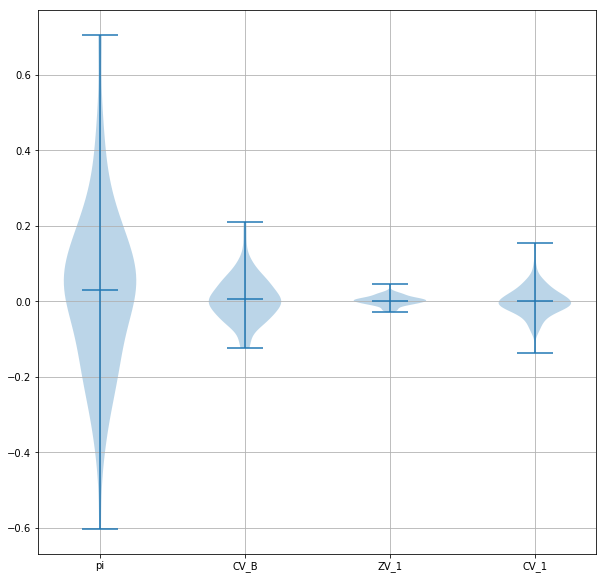

In [113]:
all_data = [P_test]
all_data.append(P_test - M_test.sum(axis = 0))
all_data.append(res_zv_1)
# all_data.append(res_zv_2)
all_data.append(res_cv_1)
# all_data.append(res_cv_2)
    
plt.figure(figsize=(10,10))
plt.violinplot(all_data, showmeans=True, showmedians=False)
# plt.title('violin plot')
plt.xticks(np.arange(1,5), ('pi', 'CV_B', 'ZV_1', 'CV_1'))
plt.grid()
plt.show()